
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 1 <br>
<font color=696880 size=4>
    Niloufar Abbasi 

____

# Emotion Recognition with Recurrent Neural Networks


---

## **Introduction**

In this task, you will implement a Recurrent Neural Network (RNN) to perform tweet emotion recognition. The goal is to classify tweets into one of six basic emotions: 
- **0: sadness**
- **1: joy**
- **2: love**
- **3: anger**
- **4: fear**
- **5: surprise**

We will be using a dataset of tweets, where each tweet has been labeled with one of these emotions. Throughout this notebook, you will follow step-by-step instructions to build and train your model. As you progress, you'll complete the provided TODO sections by filling in the necessary code and functions.

By the end of this exercise, you will:
- Understand how to preprocess text data for use in RNN models.
- Build and train a model using Pytorch.
- Evaluate the performance of your model on the test set.

---


---

## Task 1: Enter Your Information

Before we begin, please enter your **student ID** and **name** in the code section below.

Make sure to replace the placeholders with your actual information.

---

In [1]:
student_name = "Mahdi Tabatabaei"  # Replace with your name
student_id   = 400101515  # Replace with your student ID

print("Your name:", student_name)
print("Your student ID:", student_id)

Your name: Mahdi Tabatabaei
Your student ID: 400101515


---

## Task 2: Setup and Imports

In this task, we'll be preparing our environment by importing the necessary libraries. Please run the cells below to set everything up. If any library is missing on your end, make sure to install it.

### Instructions:
1. **Run the cells** to install any required packages and import the necessary libraries.
2. If any library is not installed in your environment, use `!pip install <library_name>` to install it.
---

In [ ]:
!pip install datasets

In [2]:
import warnings
warnings.filterwarnings('ignore')

Required Libraries:

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from datasets import load_dataset
from transformers import BertTokenizer
import collections
import seaborn as sns
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchinfo import summary
from types import SimpleNamespace

%matplotlib inline

### Additional Functions

The following functions have been provided to help you visualize the results of your model training. These will allow you to analyze both the model's performance over time (through the training history) and how well it performs on individual predictions (through a confusion matrix).

1. **`plot_history(hist)`**: This function takes the training history object (`hist`) from your model and plots both the accuracy and loss over the number of epochs for both training and validation sets. It provides an easy way to visually track the model's learning progress and performance.

2. **`visualize_confusion_matrix(actual_labels, predicted_labels, classes)`**: After making predictions with your model, you can use this function to plot a confusion matrix. It shows the accuracy of your model across each class, helping to identify areas where the model is performing well and where it might be struggling. The matrix is normalized to make comparisons easier.

These functions are for your convenience, you can directly use them after running your model to visualize the results.


In [4]:
# Functions to visualize training history and confusion matrix
def plot_history(hist):
    epochs = len(hist.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs), hist.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs), hist.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs), hist.history.get('loss'), label='Training')
    plt.plot(range(0, epochs), hist.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize_confusion_matrix(actual_labels, predicted_labels, classes):

    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


---

## Task 3: Importing Data

In this task, we will

- import the Tweet Emotion dataset

- create training, validation, and test sets
    
- extract the tweets and their corresponding labels for further analysis

---

In [5]:
dataset = load_dataset('emotion')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
print(dataset['train'][0:5]) 

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [7]:
training = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [8]:
def extract_tweets_labels(data):
    tweets = [entry['text'] for entry in data]
    labels = [entry['label'] for entry in data]
    return tweets, labels

tweets, labels = extract_tweets_labels(training)

print(tweets[0], labels[0])


i didnt feel humiliated 0


---

## Task 4: Tokenization of Tweets

In this section, we will focus on the tokenization of the tweets in the dataset. Tokenization is a crucial step in natural language processing (NLP) that involves breaking down text into smaller units, such as words or subwords. This process enables the model to better understand and analyze the text data.

### Objectives:
1. Implement a tokenizer to convert the tweet texts into tokens.
2. Ensure the tokenization process handles various aspects of the text, such as punctuation and special characters.

By the end of this task, you will have a set of tokenized tweets ready for further processing in your NLP pipeline.

---

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_tweets(tweets):
    tokenized_tweets = [tokenizer.tokenize(tweet) for tweet in tweets]
    return tokenized_tweets

sample_tweet = tweets[0]
tokenized_sample = tokenizer.tokenize(sample_tweet)

print("Original Tweet:", sample_tweet)
print("Tokenized Tweet:", tokenized_sample)

tokenized_tweets = tokenize_tweets(tweets)


Original Tweet: i didnt feel humiliated
Tokenized Tweet: ['i', 'didn', '##t', 'feel', 'humiliated']


---

## Task 5: Padding and Truncating Sequences

In this task, we will prepare the tokenized tweets for model training by checking their lengths and creating padded sequences.

1. **Checking the Length of the Tweets**
   - Analyze the distribution of tweet lengths to understand the range of token counts in the dataset.

2. **Creating Padded Sequences**
   - After tokenizing the tweets, sequences of different lengths must be adjusted to a uniform length to facilitate training.

---


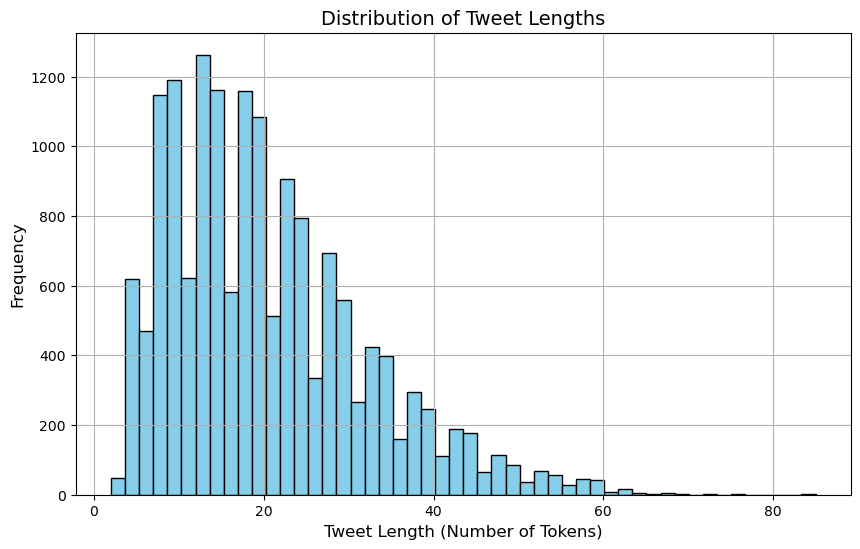

Min Length: 2
Max Length: 85
Mean Length: 20.2595
Median Length: 18


In [10]:
def calculate_lengths(tweets):
    tweet_lengths = [len(tokenizer.tokenize(tweet)) for tweet in tweets]
    return tweet_lengths

tweet_lengths = calculate_lengths(tweets)

plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths', fontsize=14)
plt.xlabel('Tweet Length (Number of Tokens)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

print(f"Min Length: {min(tweet_lengths)}")
print(f"Max Length: {max(tweet_lengths)}")
print(f"Mean Length: {sum(tweet_lengths)/len(tweet_lengths)}")
print(f"Median Length: {sorted(tweet_lengths)[len(tweet_lengths)//2]}")

In [11]:
def get_sequences(tokenizer, tweets,max_length=128):
    sequences = tokenizer(
        tweets,                     
        max_length=max_length,      
        padding='max_length',       
        truncation=True,            
        return_tensors='pt'         
    )
    padded_sequences = sequences['input_ids']
    return padded_sequences


padded_train_sequences = get_sequences(tokenizer, tweets)
padded_train_sequences[0]

tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

---

## Task 6: Analyzing Label Distribution

1. Checking the distribution of labels.
2. Addressing any class imbalance using appropriate techniques.

Note:

(**Providing a clear explanation of the chosen method to address the imbalance and how it will improve the model’s performance is critical.** Without handling class imbalance properly, the model could achieve a high accuracy by focusing on the majority class, but it may perform poorly on the minority class, which would result in misleading metrics and reduced generalization.

Hence, it is important to not only implement an appropriate solution but also **justify** why the selected approach is effective for the given task.)

---

### Addressing Class Imbalance Based on Your Code

The code snippet provided calculates the distribution of labels in terms of counts and percentages. This information is crucial to identify any imbalance in the dataset. Based on this, here is a method to address the imbalance and how it improves the model's performance:

---

#### **Method: Weighted Loss Function**
Using the label distribution percentages calculated in your code, you can assign class weights proportional to the inverse frequency of each class. This ensures that minority classes are given more importance during training, while majority classes are weighted less.

**Steps:**
1. Use the `label_percentages` dictionary in your code to compute class weights:
   ```python
   class_weights = {k: 1 / v for k, v in label_percentages.items()}
    ```
Alternatively, scale these weights to sum to 1 if preferred.

2. Pass these weights to your model's loss function:
In PyTorch, pass the weights to the weight argument of your loss function (e.g., CrossEntropyLoss).

How This Improves Model Performance?

Balances Contribution of Classes: By assigning higher weights to underrepresented classes, the model pays more attention to minority classes during training.
Prevents Bias: The model doesn't overfit to majority classes since their contributions to the loss are reduced.

Improves Generalization: By focusing on all classes, the model becomes more robust and performs better across all labels, leading to improved accuracy and reduced misclassification.

In [12]:
label_mappings = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

label_counts = collections.Counter(labels)
label_counts_named = {label_mappings[k]: v for k, v in label_counts.items()}
total_samples = sum(label_counts_named.values())
label_percentages = {label: (count / total_samples) * 100 for label, count in label_counts_named.items()}

print("Label Distribution:")
for label, count in label_counts_named.items():
    percentage = label_percentages[label]
    print(f"{label}: {count} samples ({percentage:.2f}%)")


Label Distribution:
sadness: 4666 samples (29.16%)
anger: 2159 samples (13.49%)
love: 1304 samples (8.15%)
surprise: 572 samples (3.57%)
fear: 1937 samples (12.11%)
joy: 5362 samples (33.51%)


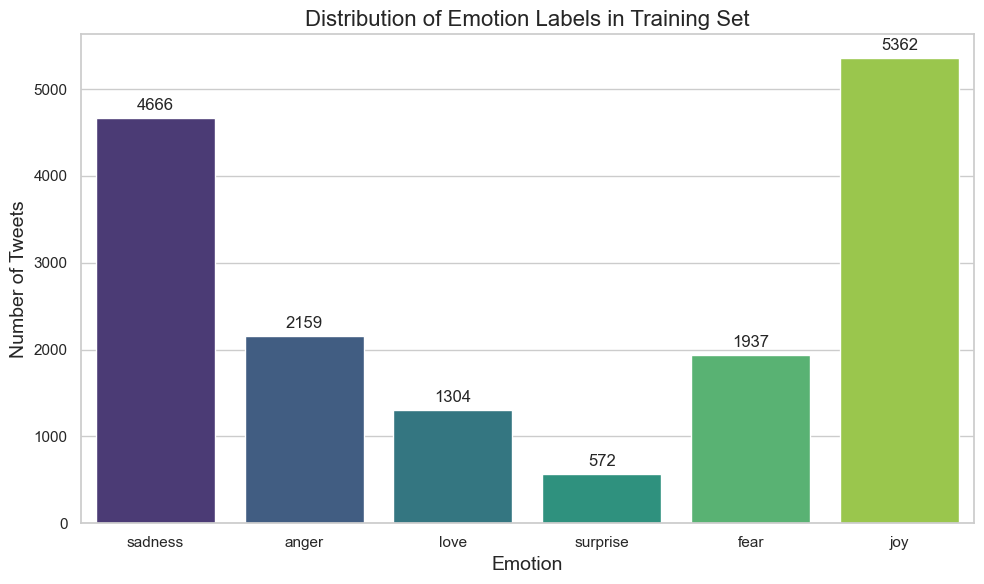

In [13]:
sns.set(style="whitegrid")

labels_list = list(label_counts_named.keys())
counts = list(label_counts_named.values())

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=labels_list, y=counts, palette="viridis")

plt.title('Distribution of Emotion Labels in Training Set', fontsize=16)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)

for index, value in enumerate(counts):
    plt.text(index, value + max(counts)*0.01, str(value), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [14]:
class_counts = np.array(counts, dtype=np.float32)
class_weights = 1.0 / class_counts
class_weights = class_weights * (len(class_counts) / class_weights.sum())
class_weights_tensor = torch.tensor(class_weights)

print("Class Weights:", class_weights_tensor)

Class Weights: tensor([0.3301, 0.7134, 1.1812, 2.6928, 0.7952, 0.2873])


---

## Task 7: Creating the Model

Design and implement a recurrent neural network for the task. You may utilize a sequential architecture like RNN or GRU to enhance the model's performance.

Build and compile your model using Pytorch.

**Once the model is created, summarize its structure to verify the design.**

---

In [15]:
class EmotionBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers, bidirectional, dropout, pad_idx):
        super(EmotionBiLSTM, self).__init__()
        
        # 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # 2. Bidirectional LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            batch_first=True,
                            dropout=dropout if n_layers > 1 else 0)
        
        # 3. Dropout Layer
        self.dropout = nn.Dropout(dropout)
        
        # 4. Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
    def forward(self, text):
        
        # 1. Embedding
        embedded = self.embedding(text)
        
        # 2. LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # 3. Concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        # 4. Dropout
        hidden = self.dropout(hidden)
        
        # 5. Fully Connected Layer
        output = self.fc(hidden)
        
        return output


In [28]:
VOCAB_SIZE = tokenizer.vocab_size 
EMBEDDING_DIM = 128                
HIDDEN_DIM = 256           
OUTPUT_DIM = 6
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5                      
PAD_IDX = tokenizer.pad_token_id   

model = EmotionBiLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [30]:
summary(model)    

Layer (type:depth-idx)                   Param #
EmotionBiLSTM                            --
├─Embedding: 1-1                         3,906,816
├─LSTM: 1-2                              2,367,488
├─Dropout: 1-3                           --
├─Linear: 1-4                            3,078
Total params: 6,277,382
Trainable params: 6,277,382
Non-trainable params: 0

In [31]:
labels_tensor = torch.tensor(labels)
train_dataset = TensorDataset(padded_train_sequences, labels_tensor)
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

---

## Task 8: Training the Model

In this task, you will prepare a validation set and train your model using the training data.

1. Prepare the validation set by extracting tweets and labels, and convert them into sequences using the tokenizer.
2. Train the model on the training data.
3. Ensure that you implement **Early Stopping** to prevent overfitting and enhance efficiency.

Make sure to monitor the validation accuracy during training and adjust the parameters as necessary.

---

In [32]:
val_tweets, val_labels = extract_tweets_labels(validation)
padded_val_sequences = get_sequences(tokenizer, val_tweets)
val_labels_tensor = torch.tensor(val_labels)
val_dataset = TensorDataset(padded_val_sequences, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [33]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
criterion = criterion.to(device)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

history = {
    'loss': train_loss_list,
    'accuracy': train_acc_list,
    'val_loss': val_loss_list,
    'val_accuracy': val_acc_list
}

history_obj = SimpleNamespace(history=history)

EPOCHS = 50
PATIENCE = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
best_model_state = None

for epoch in range(EPOCHS):
    if early_stop:
        print("Early stopping triggered.")
        break

    model.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        epoch_correct += (preds == targets).sum().item()
        epoch_total += inputs.size(0)

    train_loss = epoch_loss / epoch_total
    train_acc = epoch_correct / epoch_total

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == targets).sum().item()
            val_total += inputs.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save the best model
    else:
        epochs_no_improve += 1

    # Check if early stopping should be triggered
    if epochs_no_improve >= PATIENCE:
        print("Early stopping triggered.")
        early_stop = True

Epoch 1/50 | Train Loss: 1.4027 | Train Acc: 27.69% | Val Loss: 1.2108 | Val Acc: 38.90%
Epoch 2/50 | Train Loss: 0.9395 | Train Acc: 55.61% | Val Loss: 0.8315 | Val Acc: 62.85%
Epoch 3/50 | Train Loss: 0.5581 | Train Acc: 74.47% | Val Loss: 0.4561 | Val Acc: 79.25%
Epoch 4/50 | Train Loss: 0.3037 | Train Acc: 85.49% | Val Loss: 0.3586 | Val Acc: 87.00%
Epoch 5/50 | Train Loss: 0.2058 | Train Acc: 90.11% | Val Loss: 0.3120 | Val Acc: 87.40%
Epoch 6/50 | Train Loss: 0.1634 | Train Acc: 92.11% | Val Loss: 0.2769 | Val Acc: 87.65%
Epoch 7/50 | Train Loss: 0.1180 | Train Acc: 94.14% | Val Loss: 0.2939 | Val Acc: 89.15%
Epoch 8/50 | Train Loss: 0.0880 | Train Acc: 95.32% | Val Loss: 0.3040 | Val Acc: 88.85%
Epoch 9/50 | Train Loss: 0.0796 | Train Acc: 95.73% | Val Loss: 0.3368 | Val Acc: 89.60%
Epoch 10/50 | Train Loss: 0.0616 | Train Acc: 96.66% | Val Loss: 0.4103 | Val Acc: 89.40%
Epoch 11/50 | Train Loss: 0.0498 | Train Acc: 97.21% | Val Loss: 0.4132 | Val Acc: 90.05%
Early stopping trig

In [34]:
# # Load the best model state
# if best_model_state is not None:
#     model.load_state_dict(best_model_state)
#     print("Loaded the best model state.")
# else:
#     print("No improvement during training.")

# Save the best model to a file
torch.save(best_model_state, 'best_emotion_bilstm_model.pt')
print("Best model saved to 'best_emotion_bilstm_model.pt'.")


Best model saved to 'best_emotion_bilstm_model.pt'.


---

## Task 9: Evaluating the Model

In this task, you will evaluate the performance of your model on the test set and visualize the training history. You will also analyze the model’s predictions on both individual and complete test samples.

### Steps:
1. Visualize the loss and accuracy over the training epochs.
2. Prepare and preprocess the test data using functions from Task 2.
3. Evaluate the model on the test set and examine individual predictions.
4. Analyze the overall predictions and display a confusion matrix.

---

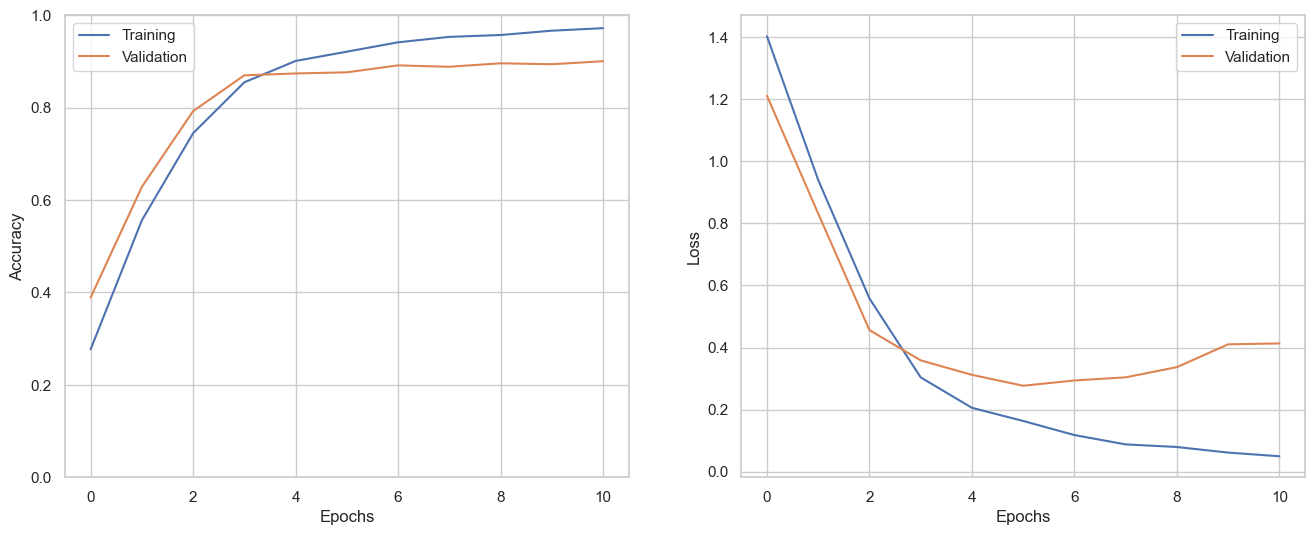

In [35]:
history = {
    'loss': train_loss_list,
    'accuracy': train_acc_list,
    'val_loss': val_loss_list,
    'val_accuracy': val_acc_list
}

history_obj = SimpleNamespace(history=history)

plot_history(history_obj)

In [36]:
test_tweets, test_labels = extract_tweets_labels(test)
padded_test_sequences = get_sequences(tokenizer, test_tweets, max_length=128)
test_labels_tensor = torch.tensor(test_labels)
test_dataset = TensorDataset(padded_test_sequences, test_labels_tensor)
BATCH_SIZE = 64 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [37]:
all_test_preds = []
all_test_labels = []

model.eval()

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(targets.cpu().numpy())

test_correct = sum([p == t for p, t in zip(all_test_preds, all_test_labels)])
test_total = len(all_test_labels)
test_accuracy = test_correct / test_total

print(f'Test Accuracy: {test_accuracy*100:.2f}%')


Test Accuracy: 89.35%


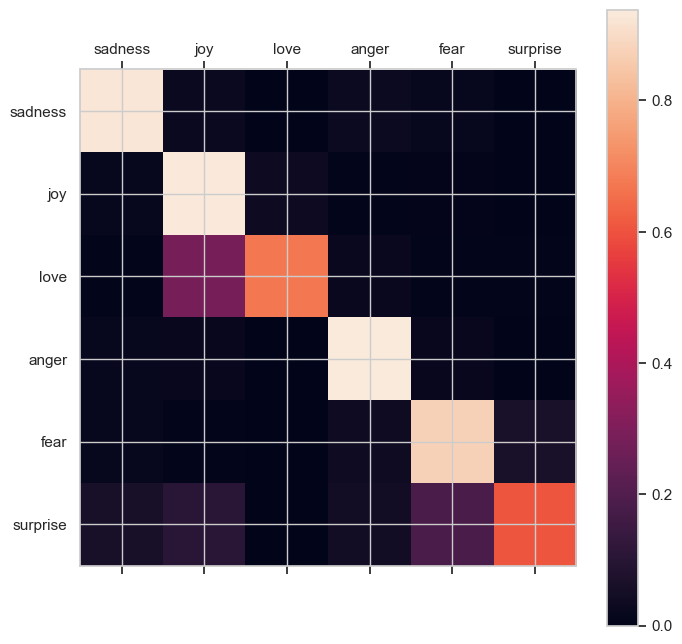

In [38]:
label_mappings = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

classes = [label_mappings[i] for i in range(len(label_mappings))]

visualize_confusion_matrix(all_test_labels, all_test_preds, classes)


In [39]:
report = classification_report(all_test_labels, all_test_preds, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     sadness       0.95      0.93      0.94       581
         joy       0.90      0.93      0.91       695
        love       0.81      0.67      0.74       159
       anger       0.87      0.94      0.91       275
        fear       0.85      0.88      0.86       224
    surprise       0.71      0.61      0.66        66

    accuracy                           0.89      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



# Final Analysis

After visualizing the confusion matrix based on your model’s predictions, analyze the results and provide insights into the model’s classification performance.

### **Question:**
<span style="font-size: 1.2em;">Which class seems to get confused with the class *love* the most?</span>

**Remember the class labels:**
- **0:** *Sadness*
- **1:** *Joy*
- **2:** *Love*
- **3:** *Anger*
- **4:** *Fear*
- **5:** *Surprise*

Reflect on the confusion matrix to answer this question and provide your reasoning for why this confusion might occur based on the emotional nature of the classes.


#### **Reasoning:**
- In the confusion matrix, the row for **love** (row index 2) shows a relatively high off-diagonal value in the column for **joy** (column index 1). This indicates that samples labeled as **love** are often predicted as **joy**.
- This confusion might occur due to the emotional overlap between the two classes. Both **love** and **joy** are positive emotions and often share similar language, sentiment, or expressions in data, leading the model to struggle in distinguishing them accurately.

---

#### **Suggestions to Reduce Confusion:**
1. **Provide More Representative Data:**
   - Collect additional examples of both **love** and **joy** that emphasize their distinct characteristics.
2. **Data Augmentation:**
   - Use techniques to enrich the dataset with unique samples of each class.
3. **Feature Engineering:**
   - Extract features specific to each class that better capture their unique semantic or linguistic nuances.

By addressing this confusion, the model's performance on distinguishing positive emotions like **love** and **joy** can be significantly improved.

# **Best regards.**